In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
import zipfile
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook
import numpy as np

In [4]:
zip_ref = zipfile.ZipFile("imgs_details.rar", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

In [5]:
from skimage.io import imread_collection
from skimage.io import imread
col_dir1 = '/content/sample_data/test/big/*.jpeg'
col_dir2 = '/content/sample_data/test/small/*.jpeg'
col_dir3 = '/content/sample_data/train/big/*.jpeg'
col_dir4 = '/content/sample_data/train/small/*.jpeg'
col1 = imread_collection(col_dir1)
col2 = imread_collection(col_dir2)
col3 = imread_collection(col_dir3)
col4 = imread_collection(col_dir4)

In [6]:
images_test = []
labels_test = []
images_train = []
labels_train = []
for i in col1:
    labels_test.append(1)
    images_test.append(i)
for i in col2:
    labels_test.append(0)
    images_test.append(i)
for i in col3:
    labels_train.append(1)
    images_train.append(i)
for i in col4:
    labels_train.append(0)
    images_train.append(i)

In [13]:
(len(images_test[0]), len(images_test[0][0]))

(4032, 3024)

Каждое изображение имеет размер (4032, 3024) пикселей, что слишком много, уменьшим его до (256, 256) и посмотрим что получится.

In [14]:
size = (256, 256)
X_test = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images_test]
X_train = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images_train]

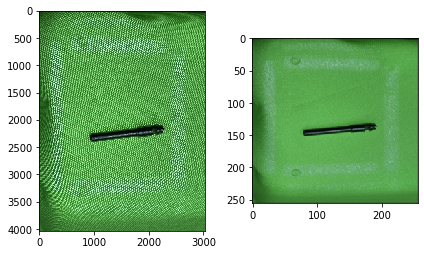

In [15]:
plt.subplot(1, 2, 1)
io.imshow(images_test[0])
plt.subplot(1, 2, 2)
io.imshow(X_test[0])
plt.show()

Как видим, главные признаки картинки остались на месте (размер детали), а модель будет обучаться гораздо быстрее за счет уменьшения размерности.

In [17]:
images_train_new = np.zeros((len(images_train), 3, 256, 256))
images_test_new = np.zeros((len(images_test), 3, 256, 256))
for k in range(len(images_train)):
    for i in range(256):
        for j in range(256):
            for c in range(3):
                images_train_new[k][c][i][j] = X_train[k][i][j][c]
for k in range(len(images_test)):
    for i in range(256):
        for j in range(256):
            for c in range(3):
                images_test_new[k][c][i][j] = X_test[k][i][j][c]   

In [23]:
X_test = images_test_new
X_train = images_train_new

В предыдущей ячейке немного изменим формат ввода наших изображений, они изначально имели размерность (256, 256, 3), а нам нужно (3, 256, 256)

In [24]:
batch_size = 4
data_tr = DataLoader(list(zip(X_train, labels_train)), 
                     batch_size=batch_size, shuffle=True)
data_test = DataLoader(list(zip(X_test, labels_test)),
                      batch_size=batch_size, shuffle=False)

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Построим простенькую Сверточную нейронную сеть из 5 слоев

In [59]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(3456, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

Напишем функции для обучения модели

In [57]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [54]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [30]:
def train(train_loader, val_loader, model, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

Функция для предсказания

In [72]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs, _ in test_loader:
            inputs = inputs.to(device).float()
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [64]:
simple_cnn = SimpleCnn(2).cuda()

Само обучение (в качестве функции потерь взяли бинарную кросс энтропию, а оптимизатором выбрали Adam)

In [65]:
history = train(data_tr, data_test, model=simple_cnn, epochs=20)

epoch:   5%|▌         | 1/20 [00:00<00:03,  4.76it/s]

loss 0.6807266113369964

Epoch 001 train_loss: 0.6807     val_loss 0.6603 train_acc 0.5814 val_acc 0.6190


epoch:  10%|█         | 2/20 [00:00<00:03,  4.65it/s]

loss 0.6771446910015372

Epoch 002 train_loss: 0.6771     val_loss 0.6494 train_acc 0.6279 val_acc 0.6190


epoch:  15%|█▌        | 3/20 [00:00<00:03,  4.65it/s]

loss 0.6363993592040483

Epoch 003 train_loss: 0.6364     val_loss 0.6133 train_acc 0.6279 val_acc 0.6190


epoch:  20%|██        | 4/20 [00:00<00:03,  4.76it/s]

loss 0.6022301953892375

Epoch 004 train_loss: 0.6022     val_loss 0.4586 train_acc 0.6512 val_acc 0.8095
loss 0.3353796489455542



Epoch 005 train_loss: 0.3354     val_loss 0.3146 train_acc 0.8837 val_acc 0.7143
loss 0.17179246000988885


epoch:  35%|███▌      | 7/20 [00:01<00:02,  4.85it/s]


Epoch 006 train_loss: 0.1718     val_loss 0.1016 train_acc 0.8837 val_acc 1.0000
loss 0.03737379523226991


epoch:  40%|████      | 8/20 [00:01<00:02,  4.93it/s]


Epoch 007 train_loss: 0.0374     val_loss 0.0133 train_acc 1.0000 val_acc 1.0000
loss 0.005409219030826894

Epoch 008 train_loss: 0.0054     val_loss 0.0044 train_acc 1.0000 val_acc 1.0000


epoch:  45%|████▌     | 9/20 [00:01<00:02,  5.04it/s]

loss 0.0296090980785287

Epoch 009 train_loss: 0.0296     val_loss 0.0008 train_acc 1.0000 val_acc 1.0000
loss 0.00026211470432680167


epoch:  55%|█████▌    | 11/20 [00:02<00:01,  5.17it/s]


Epoch 010 train_loss: 0.0003     val_loss 0.0006 train_acc 1.0000 val_acc 1.0000
loss 0.0005208269885766973

Epoch 011 train_loss: 0.0005     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000


epoch:  60%|██████    | 12/20 [00:02<00:01,  5.23it/s]

loss 1.5310720728785085e-05

Epoch 012 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 2.3432850692315275e-05


epoch:  70%|███████   | 14/20 [00:02<00:01,  5.32it/s]


Epoch 013 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 2.810087178491934e-05

Epoch 014 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000


epoch:  75%|███████▌  | 15/20 [00:02<00:00,  5.35it/s]

loss 1.74869938180479e-05

Epoch 015 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 1.220060507320827e-05


epoch:  85%|████████▌ | 17/20 [00:03<00:00,  5.39it/s]


Epoch 016 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 9.913580564168729e-06

Epoch 017 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000


epoch:  90%|█████████ | 18/20 [00:03<00:00,  5.41it/s]

loss 8.70213799504559e-06

Epoch 018 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 8.302936279516532e-06


epoch: 100%|██████████| 20/20 [00:03<00:00,  5.14it/s]


Epoch 019 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000
loss 8.111649279715832e-06

Epoch 020 train_loss: 0.0000     val_loss 0.0000 train_acc 1.0000 val_acc 1.0000


In [66]:
loss, acc, val_loss, val_acc = zip(*history)

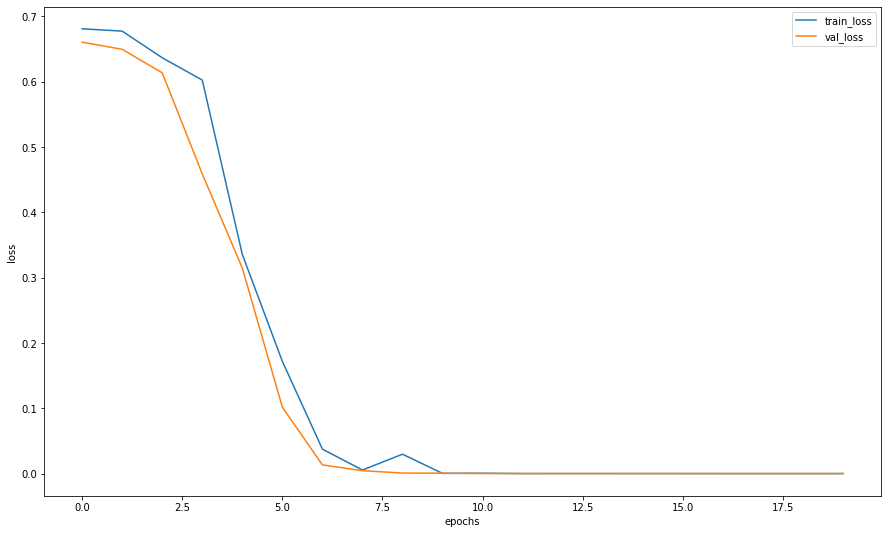

In [67]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Как можно заметить, 20 эпох вполне хватило чтобы сеть всегда отличала большие детали от маленьких

In [86]:
ans = predict(simple_cnn, data_test)

In [87]:
ans = list(torch.argmax(torch.Tensor(ans), 1).numpy())

In [89]:
ans == labels_test

True

Видим, что наша модель правильно разпознает все детали из тестовой выборки

In [91]:
print("Предсказания:", ans)
print("Правильные отв.:", labels_test)

Предсказания: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Правильные отв.: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Тут 1 - это большая деталь, 0 - маленькая